In [8]:
from model import model
from model import *

import data_loader
import matplotlib.pyplot as plt
import numpy as np
from torchvision import transforms
import torch

%load_ext autoreload
%autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Data iteration testing

In [34]:
bs=2
frames = data_loader.get_datasets(32,bs)[0]
imgs= next(iter(frames))

In [35]:
imgs[0].shape

torch.Size([2, 3, 32, 32])

RDN

In [36]:
c = model.conv_feature_extractor.RDN(3,5,5,3,2)

In [37]:
feats=c(imgs[0])

Create graph from features

In [38]:
imsize = imgs[0].shape[-1]

In [39]:
grids = torch.cat([x.unsqueeze(0) for x in torch.meshgrid([torch.linspace(-1, 1, imsize) for _ in range(2)])])

In [40]:
batch_coords = grids.unsqueeze(0).repeat(bs,*[1]*len(grids.shape))

In [41]:
batch_coords_added = torch.cat([batch_coords,feats],axis=1)

In [42]:
# Maps x,y to index in flattened list
flat_indices = np.arange(imsize**2).reshape((imsize,imsize)) 
# Create flattened adjacency list
adj_list = [[flat_indices[x,y],flat_indices[neighbx,neighby]]
                # For (very cell
                for x,y in [(x,y) for x in range(imsize) for y in range(imsize)]
                    # Every valid neighbor of current cell
                    for neighbx,neighby in [(x+xd,y+yd) for xd in range(-1,2) for yd in range(-1,2) 
                                   if -1<x+xd<imsize and -1<y+yd<imsize] ]
edge_tensor = torch.tensor(adj_list).t().contiguous()

In [43]:
from torch_geometric.data import Data,Batch

In [44]:
flat_feats = torch.flatten(batch_coords_added,2,3).permute(0,2,1)

In [45]:
t=Batch.from_data_list([Data(x,edge_tensor) for x in flat_feats])

In [46]:
t.x.shape

torch.Size([2048, 7])

In [47]:
b_data=Data(x=flat_feats,edge_index=edge_tensor)

In [48]:
b_data.x.shape

torch.Size([2, 1024, 7])

In [50]:
#bb_data=Batch.from_data_list([Data(b_data.x[i],b_data.edge_index) for i in range(b_data.x.shape[0])])
bb_data=Batch.from_data_list([Data(b_data.x[i],b_data.edge_index) for i in range(bs)])

In [52]:
from torch_geometric.utils import to_dense_adj, dense_to_sparse
dense_adj=to_dense_adj(bb_data.edge_index,bb_data.batch)
dense_adj.shape

torch.Size([2, 1024, 1024])

In [55]:
b=bb_data
b.to_data_list()

[Data(edge_index=[2, 8836], x=[1024, 7]),
 Data(edge_index=[2, 8836], x=[1024, 7])]

Graph module testing

In [254]:
from model import graph_bottleneck

In [255]:
gb=graph_bottleneck.ObjGraph(7,2)

In [256]:
out_graph=gb(bb_data)

In [257]:
out_graph[1].shape

torch.Size([3, 4988, 7])

In [104]:
for x in out_graph:print(x.shape)

torch.Size([26141, 7])
torch.Size([2, 257865])
torch.Size([26141])


AttributeError: 'UnpoolDescription' object has no attribute 'shape'

In [164]:
torch_geometric.utils.to_dense_batch(out_graph[0],out_graph[2]+1)[0].shape

RuntimeError: Invalid index in scatterAdd at /pytorch/aten/src/TH/generic/THTensorEvenMoreMath.cpp:721
The above operation failed in interpreter.
Traceback (most recent call last):
  File "/home/cos008/.local/lib/python3.7/site-packages/torch_scatter/scatter.py", line 22
            size[dim] = int(index.max()) + 1
        out = torch.zeros(size, dtype=src.dtype, device=src.device)
        return out.scatter_add_(dim, index, src)
               ~~~~~~~~~~~~~~~~ <--- HERE
    else:
        return out.scatter_add_(dim, index, src)


In [203]:
from torch_scatter import scatter_add
x,batch=out_graph[0],out_graph[2]
batch_size = batch.max()+1
num_nodes = scatter_add(batch.new_ones(x.size(0)), batch, dim=0,
                        dim_size=batch_size)
cum_nodes = torch.cat([batch.new_zeros(1), num_nodes.cumsum(dim=0)])

max_num_nodes = num_nodes.max().item()

idx = torch.arange(batch.size(0), dtype=torch.long, device=x.device)
idx = (idx - cum_nodes[batch]) + (batch * max_num_nodes)

size = [batch_size * max_num_nodes] + list(x.size())[1:]
out = x.new_full(size, 0)
out[idx] = x
out = out.view([batch_size, max_num_nodes] + list(x.size())[1:])

In [202]:
x.sh

AttributeError: 'Tensor' object has no attribute 'append'

In [ ]:
ba

In [190]:
tmp=Data(x=out_graph[0],edge_index=out_graph[1])
tmp2=Batch([tmp])

In [191]:
import torch_geometric.utils.to_dense_batch

In [192]:
dense=torch_geometric.utils.to_dense_batch(out_graph[0],out_graph[2])

RuntimeError: Invalid index in scatterAdd at /pytorch/aten/src/TH/generic/THTensorEvenMoreMath.cpp:721
The above operation failed in interpreter.
Traceback (most recent call last):
  File "/home/cos008/.local/lib/python3.7/site-packages/torch_scatter/scatter.py", line 22
            size[dim] = int(index.max()) + 1
        out = torch.zeros(size, dtype=src.dtype, device=src.device)
        return out.scatter_add_(dim, index, src)
               ~~~~~~~~~~~~~~~~ <--- HERE
    else:
        return out.scatter_add_(dim, index, src)


In [65]:
dense[1]

tensor([[False, False,  True,  ...,  True,  True,  True],
        [ True, False,  True,  ...,  True,  True,  True],
        [ True, False,  True,  ...,  True,  True,  True],
        [False,  True, False,  ..., False, False, False]])

Hypernetwork generation testing

In [146]:
from model import hypernet_img_gen

In [147]:
hp=hypernet_img_gen.HyperNetImgGen(128,5,12).cuda()

In [29]:
phi=hp(b_data.x)

RuntimeError: CUDA out of memory. Tried to allocate 16.06 GiB (GPU 0; 10.92 GiB total capacity; 620.38 MiB already allocated; 9.24 GiB free; 1.11 GiB reserved in total by PyTorch)

In [ ]:
phi[0].reshape(imsize,imsize,3)

Global module testing

In [317]:
from model.model import model

In [318]:
m = model().cuda()

In [319]:
out=m(imgs[0].cuda())

In [320]:
out[0].shape,out[1].shape

(torch.Size([4, 16384, 3]), torch.Size([4, 16384, 3]))

In [324]:
m

model(
  (conv_encoder): RDN(
    (sfe1): Conv2d(3, 5, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (sfe2): Conv2d(5, 5, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (rdbs): ModuleList(
      (0): RDB(
        (layers): Sequential(
          (0): DenseLayer(
            (conv): Conv2d(5, 5, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            (relu): ReLU(inplace=True)
          )
          (1): DenseLayer(
            (conv): Conv2d(10, 5, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            (relu): ReLU(inplace=True)
          )
        )
        (lff): Conv2d(15, 5, kernel_size=(1, 1), stride=(1, 1))
      )
      (1): RDB(
        (layers): Sequential(
          (0): DenseLayer(
            (conv): Conv2d(5, 5, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            (relu): ReLU(inplace=True)
          )
          (1): DenseLayer(
            (conv): Conv2d(10, 5, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            (relu): R

In [331]:
(out[0]-out[1]).abs().sum()

tensor(43273.5859, device='cuda:0', grad_fn=<SumBackward0>)

In [337]:
torch.nn.L1Loss()(out[0].flatten(),imgs[0].cuda().flatten())

tensor(0.5959, device='cuda:0', grad_fn=<L1LossBackward>)

Experiment testing

In [1]:
import run
tmp=run.Experiment().run()

Epoch 0
epoch: 0, val: 0/, element: 0/4518, loss: 2.125770


In [10]:
import matplotlib.pyplot as plt
im=tmp[0].resize(256,256,3).cpu().detach().numpy()

In [18]:
im.min()

-0.81165206

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


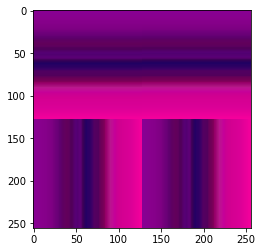

In [32]:
plt.imshow(im)
plt.savefig("experiments/output_imgs/test.png")

In [33]:
from torchvision.utils import save_image
save_image(tmp[0].resize(3,256,256), 'experiments/output_imgs/test.png')

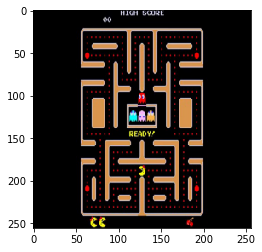

In [11]:
im=plt.imread("frames/pacman_450.jpg")
from skimage.transform import rescale, resize

plt.imshow(resize(im,(256,256)))

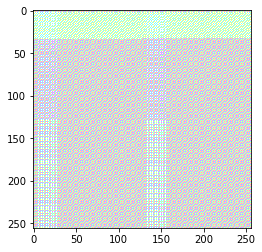

In [30]:
plt.imshow(plt.imread("experiments/output_imgs/test.png"))

In [31]:
image = tmp.cpu().clone()
x = image.clamp(0, 1)
x = x.view(x.size(0), 3, 256, 256)
save_image(x, "experiments/output_imgs/test.png")